# requirements

In [ ]:
import pandas as pd
import os
import scipy.io as sio
import numpy as np
import random
from random import randrange, shuffle, random, randint

import math
import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt

# Load data and tokenize

In [ ]:
class PabloDNADataset:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, sep="\t", encoding="unicode_escape")

    def clean_nan(self, col_names, replace_orig=False):
        clean_df = self.df.dropna(subset=col_names)
        clean_df = clean_df.reset_index(drop=True)
        if replace_orig:
            self.df = clean_df
        return clean_df
    
    def change_RXY2N(self, col_names, replace_orig=False):
      full_pattern = re.compile('[^ACGTN\-]') 
      self.df[col_names] = self.df[col_names].apply(lambda x: re.sub(full_pattern, 'N', x))
      # if replace_orig:
      #   self.df[col_names] = clean_nucleotides
      # return clean_str_df


    def generate_mini_sample(self, dataframe=None, bin_count=20, output_path="mini_sample.tsv"):
        if dataframe is None:
            dataframe = self.df
        bins = list(dataframe['bin_uri'].unique())
        rd1 = random.sample(range(0, len(bins)), bin_count)
        bins = [bins[i] for i in rd1]
        mini_df = dataframe.loc[dataframe['bin_uri'].isin(bins)]
        mini_df = mini_df.reset_index(drop=True)
        # mini_df = dataframe.iloc[0:sample_count]
        # mini_df = dataframe.take(np.random.permutation(len(dataframe))[:sample_count])
        mini_df.to_csv(output_path, sep="\t")

    def get_info(self, dataframe=None):
        if dataframe is None:
            dataframe = self.df
        print("Total data: ", len(dataframe))
        print("Number of bin clusters: ", len(dataframe['bin_uri'].unique()))



In [ ]:
def tokenizer(dna_sentence, k_mer_dict, k_mer_length, stride=1):
    tokens = []
    for i in range(0, len(dna_sentence) - k_mer_length + 1, stride):
        k_mer = dna_sentence[i:i + k_mer_length]
        tokens.append(k_mer_dict[k_mer])
    return tokens



class SampleDNAData(Dataset):
    """Barcode Dataset"""

    @staticmethod
    def get_all_kmers(k_mer_length, alphabet=None) -> list:
        """
        :rtype: object
        """

        def base_convert(num, base, length):
            result = []
            while num > 0:
                result.insert(0, num % base)
                num = num // base
            while len(result) < length:
                result.insert(0, 0)
            return result

        if alphabet is None:
            alphabet = ["A", "C", "G", "T", "-", "N"]
        k_mer_counts = len(alphabet) ** k_mer_length
        all_k_mers_list = []
        for i in range(k_mer_counts):
            code = base_convert(num=i, base=len(alphabet), length=k_mer_length)
            k_mer = ""
            for j in range(k_mer_length):
                k_mer += alphabet[code[j]]
            all_k_mers_list.append(k_mer)

        return all_k_mers_list

    def __init__(self, file_path, k_mer=4, data_count=8, max_mask_count=5, max_len=256):
        pablo_dataset = PabloDNADataset(file_path)
        # for removing X,R,Y letters from data
        pablo_dataset.change_RXY2N("nucleotides")
        self.dna_nucleotides = list(pablo_dataset.df["nucleotides"].values)
        word_list = SampleDNAData.get_all_kmers(k_mer)

        word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
        for i, w in enumerate(word_list):
            word_dict[w] = i + 4
            number_dict = {i: w for i, w in enumerate(word_dict)}

        self.word_dict = word_dict
        self.number_dict = number_dict

        self.vocab_size = len(word_dict)
        self.max_len = max_len

        self.batch = []
        positive = negative = 0
        while positive != data_count / 2 or negative != data_count / 2:
            is_positive = randrange(0, 2)

            tokens_a_index, tokens_b_index = 0, 0
            while tokens_a_index == tokens_b_index:
                tokens_a_index, tokens_b_index = randrange(len(self.dna_nucleotides)), randrange(
                    len(self.dna_nucleotides))

            if is_positive:
                dna_a = self.dna_nucleotides[tokens_a_index]
                dna_b = dna_a
            else:
                dna_a = self.dna_nucleotides[tokens_a_index]
                dna_b = self.dna_nucleotides[tokens_b_index]

            rand_len = randrange(128, 256)

            dna_a = dna_a[0:len(dna_a) // 2][0:rand_len]  # max_len//2 - 3]
            dna_b = dna_b[len(dna_b) // 2:][0:rand_len]  # max_len//2 - 3]
            tokens_a = tokenizer(dna_a, word_dict, k_mer, stride=1)
            tokens_b = tokenizer(dna_b, word_dict, k_mer, stride=1)
            input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
            segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

            # MASK LM
            n_pred = min(max_mask_count, max(1, int(round(len(input_ids) * 0.15))))  # 15 % of tokens in one sentence
            cand_masked_pos = [i for i, token in enumerate(input_ids)
                               if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
            shuffle(cand_masked_pos)

            # remove N and gaps from cand_masked_pos
            cand_masked_pos_copy = cand_masked_pos.copy()
            for position in cand_masked_pos_copy:
                key = list(word_dict.keys())[list(word_dict.values()).index(position)]
                if ("N" in key) or ("-" in key):
                    cand_masked_pos.remove(position)
            # if the position remains is less than 15%, mask them all
            if len(cand_masked_pos) < n_pred:
                n_pred = len(cand_masked_pos)

            masked_tokens, masked_pos = [], []
            for pos in cand_masked_pos[:n_pred]:
                masked_pos.append(pos)
                masked_tokens.append(input_ids[pos])
                # if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]']  # make mask
                # elif random() < 0.5:  # 10%
                #     index = randint(0, vocab_size - 1)  # random index in vocabulary
                #     input_ids[pos] = word_dict[number_dict[index]]  # replace

            # Zero Paddings
            n_pad = max_len - len(input_ids)
            input_ids.extend([0] * n_pad)
            segment_ids.extend([0] * n_pad)

            # Zero Padding (100% - 15%) tokens
            if max_mask_count > n_pred:
                n_pad = max_mask_count - n_pred
                masked_tokens.extend([0] * n_pad)
                masked_pos.extend([0] * n_pad)

            if is_positive and positive < data_count / 2:
                self.batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True])  # IsNext
                positive += 1
            elif not is_positive and negative < data_count / 2:
                self.batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False])  # NotNext
                negative += 1

    def __len__(self):
        return len(self.batch)

    def __getitem__(self, idx):
        ids = torch.Tensor(self.batch[idx][0])
        seg = torch.Tensor(self.batch[idx][1])
        msk_tok = torch.Tensor(self.batch[idx][2])
        msk_pos = torch.Tensor(self.batch[idx][3])
        label = torch.Tensor([self.batch[idx][4]])

        ids, seg, msk_pos = ids.type(torch.IntTensor), seg.type(torch.IntTensor), msk_pos.type(torch.int64)

        msk_tok = msk_tok.type(torch.LongTensor)
        label = label.type(torch.LongTensor)

        return ids, seg, msk_pos, msk_tok, label


# Model

In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model, maxlen, n_segments):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(int(vocab_size), int(d_model))  # token embedding
        self.pos_embed = nn.Embedding(int(maxlen), int(d_model))  # position embedding
        self.seg_embed = nn.Embedding(int(n_segments), int(d_model))  # segment(token type) embedding
        self.norm = nn.LayerNorm(int(d_model))

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)


class GELU(nn.Module):

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k


class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, d_k, d_v, n_heads)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_k)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs,
                                               enc_self_attn_mask)  # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs)  # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)

        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.d_model = d_model

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,
                                                                                 2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,
                                                                                 2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,
                                                                                 2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1,
                                                  1)  # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1,
                                                            self.n_heads * self.d_v)  # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model)(context)

        return nn.LayerNorm(self.d_model)(output + residual), attn  # output: [batch_size x len_q x d_model]


class PoswiseFeedForwardNet(nn.Module):

    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.l1 = nn.Linear(d_model, d_ff)
        self.l2 = nn.Linear(d_ff, d_model)

        self.relu = GELU()
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs
        output = self.l1(inputs)
        output = self.relu(output)
        output = self.l2(output)
        return self.layer_norm(output + residual)


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        self.d_k = d_k
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(
            self.d_k)  # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9)  # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn


class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, maxlen, n_segments, n_layers, d_k, d_v, n_heads):
        super(BERT, self).__init__()
        self.embedding = Embedding(vocab_size, d_model, maxlen, n_segments)
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_k, d_v, n_heads) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = GELU()
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            # embedding layer
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # classifier pos/neg (it will be decided by first token(CLS))
        h_pooled = self.activ1(self.fc(output[:, 0]))  # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled)  # [batch_size, 2]

        # classifier mask
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1))  # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos)  # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias  # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf, output

# Train


Mount your drive to access the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File path of the input
# input_path = "/content/drive/MyDrive/BIOSCAN/full_training.tsv"
# input_path = "/content/drive/MyDrive/BIOSCAN/medium_training.tsv"
input_path = "/content/drive/MyDrive/BIOSCAN/small_training.tsv"


# dataloader to get a batch of data
dataset = SampleDNAData(file_path=input_path, k_mer=4, data_count=256, max_mask_count=70, max_len=512)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# define the model
# DNABert configuration
config = {
    "d_model": 768,
    "n_heads": 12,
    "n_layers": 12 

}
# # first config
# config = {
#     "d_model": 16,
#     "n_heads": 2,
#     "n_layers": 5 

# }
model = BERT(dataset.vocab_size, config["d_model"], dataset.max_len, 2, config["n_layers"], 32, 32, config["n_heads"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
saving_path = "/content/drive/MyDrive/BIOSCAN/model_checkpoints_new/"
epoch_loss_list = []
training_epoch = 500
continue_epoch = 0

''' 
If you lost your connection and want to continue the training process, 
uncomment this part, load your last model, optimizer, and loss, 
choose the epoch you 
want to continue from
'''
# continue_epoch = 100
# model.load_state_dict(torch.load(saving_path + f'model_{continue_epoch}.pth'))
# optimizer.load_state_dict(torch.load(saving_path + f"optimizer_{continue_epoch}.pth"))

# a_file = open(saving_path + "loss.pkl", "rb")
# epoch_loss_list = pickle.load(a_file)



' \nIf you lost your connection and want to continue the training process, \nuncomment this part, load your last model, optimizer, and loss, \nchoose the epoch you \nwant to continue from\n'

In [ ]:
# strat training
for epoch in range(continue_epoch, training_epoch):
    epoch_loss = 0
    for ids, seg, msk_pos, masked_tokens, is_pos in dataloader:
        optimizer.zero_grad()
        logits_lm, logits_clsf, outputs= model(ids, seg, msk_pos)

        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens)  # for masked LM
        loss_lm = (loss_lm.float()).mean()
        loss_clsf = criterion(logits_clsf, torch.squeeze(is_pos))  # for sentence classification
        loss = loss_lm + loss_clsf

        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    epoch_loss_list.append(epoch_loss)

    print(f"epoch {epoch}: Loss is {epoch_loss}")

    # every 50 epoch save the checkpoints and save the loss in a list
    if epoch % 50 == 0:
        torch.save(model.state_dict(), saving_path + "model_" + str(epoch) +'.pth')
        torch.save(optimizer.state_dict(), saving_path + "optimizer_" + str(epoch) +'.pth')

        a_file = open(saving_path + "loss.pkl", "wb")
        pickle.dump(epoch_loss_list, a_file)
        a_file.close()


epoch 0: Loss is 3077.4000148773193
epoch 1: Loss is 1284.2528228759766
epoch 2: Loss is 577.8037328720093
epoch 3: Loss is 447.2536668777466
epoch 4: Loss is 371.2786350250244
epoch 5: Loss is 348.15738582611084
epoch 6: Loss is 342.93158745765686
epoch 7: Loss is 420.5345735549927
epoch 8: Loss is 396.643342256546
epoch 9: Loss is 372.49149990081787
epoch 10: Loss is 533.1799840927124
epoch 11: Loss is 482.9966721534729
epoch 12: Loss is 385.9531583786011
epoch 13: Loss is 352.0544571876526
epoch 14: Loss is 336.9014103412628
epoch 15: Loss is 353.75666427612305
epoch 16: Loss is 482.92566204071045
epoch 17: Loss is 474.91187143325806
epoch 18: Loss is 370.27308106422424
epoch 19: Loss is 344.2973601818085
epoch 20: Loss is 387.16072034835815
epoch 21: Loss is 349.3293697834015
epoch 22: Loss is 328.1490921974182
epoch 23: Loss is 364.0607998371124
epoch 24: Loss is 388.6774709224701
epoch 25: Loss is 356.7534091472626
epoch 26: Loss is 341.5543751716614
epoch 27: Loss is 333.6438570

RuntimeError: ignored

## Plot the loss after training

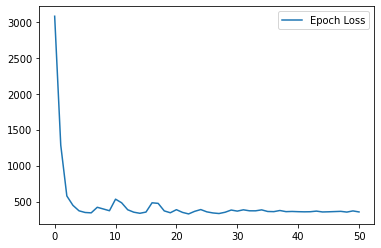

In [ ]:
plt.plot(epoch_loss_list, label ="Epoch Loss")
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/BIOSCAN/model_checkpoints_new/loss_per_epoch.png')
plt.show()